__Name/Section__

A: Kyle Adrian Santos | S12

# k-Nearest Neighbor (kNN) exercise

*This exercise is modified version of the exercise from cs231n class at Stanford University.

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

## Instructions
* Read each cell and implement the TODOs sequentially. The markdown/text cells also contain instructions which you need to follow to get the whole notebook working.
* Do not change the variable names unless the instructor allows you to.
* Answer all the markdown/text cells with "A: " on them. The answer must strictly consume one line only.
* You are expected to search how to some functions work on the Internet or via the docs. 
* You may add new cells for "scrap work".
* The notebooks will undergo a "Restart and Run All" command, so make sure that your code is working properly.
* You may not reproduce this notebook or share them to anyone.

In [12]:
!pip install matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ------------- -------------------------- 2.9/8.7 MB 15.8 MB/s eta 0:00:01
   --------------------------- ------------ 6.0/8.7 MB 15.2 MB/s eta 0:00:01
   ---------------------------------------  8.7/8.7 MB 14.2 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 13.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   -- ------------------------------------- 2.9/38.5 MB 15.5 MB/s eta 0:00:03
   ----- ---------------------------------- 5.8/38.5 MB 13.9 MB/s eta 0:00:03
   -------- ------------------------------- 8.4/38.5 MB 13.4 MB/s eta 0:00:03
   ------------ --------------------------- 11.8/38.5 MB 14.4 MB/s eta 0:00:02
   -------------- ------------------------- 14.2/38.5 MB 14.0 MB/s eta 0:00:02
   ----------------- ---------------------- 17.3/38.5 MB 14.1 MB/s eta 0:00:02
   -


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Run some setup code for this notebook.
import random
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
# Makes matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# autoreload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

__The pre-processing is not discussed in class, but you are supposed to understand the pre-processing code below in preparation for your MP:__

In [4]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)    
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

__Make sure that the `cifar-10` folder is in the same directory as this notebook. If the name of the folder is different, rename it.__

In [5]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cifar-10-python'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
# (N, H, W, C) 
# Print out the sizes of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


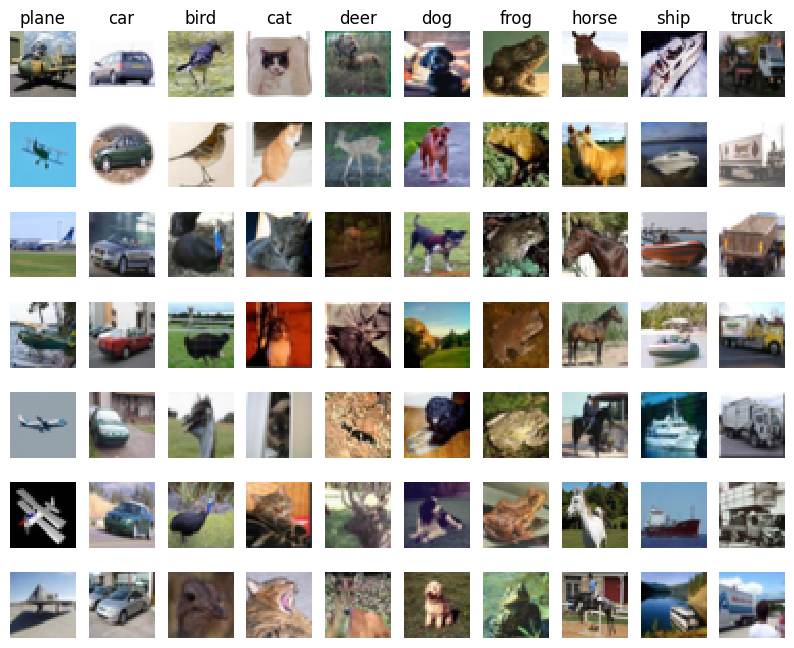

In [6]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False) 
    for i, idx in enumerate(idxs):
        # show items in column (per class)
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [7]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = range(num_training)

X_train = X_train[mask] # gets the first 500 items
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [9]:
# TODO : Reshape the image data into rows
# Hint: Lookup the reshape function in numpy
### START CODE HERE ###
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
### END CODE HERE ###

print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


## Classifier


In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [17]:
# TODO : Initialize with k=5, train, and test
### START CODE HERE ###
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
### END CODE HERE ###

# TODO : Show a classification report, and show the name of the classes
### START CODE HERE ###
print(classification_report(y_test, predictions, target_names=classes))
### END CODE HERE ###

              precision    recall  f1-score   support

       plane       0.29      0.49      0.36        57
         car       0.56      0.12      0.20        41
        bird       0.24      0.57      0.34        51
         cat       0.26      0.12      0.17        49
        deer       0.13      0.35      0.19        40
         dog       0.29      0.10      0.15        48
        frog       0.41      0.22      0.29        54
       horse       0.50      0.04      0.08        47
        ship       0.38      0.58      0.46        57
       truck       0.62      0.09      0.16        56

    accuracy                           0.28       500
   macro avg       0.37      0.27      0.24       500
weighted avg       0.37      0.28      0.25       500



__Your results should look like this:__
```
               precision    recall  f1-score   support

      plane       0.28      0.53      0.36        57
        car       0.50      0.24      0.33        41
       bird       0.19      0.53      0.28        51
        cat       0.16      0.16      0.16        49
       deer       0.11      0.25      0.15        40
        dog       0.18      0.06      0.09        48
       frog       0.17      0.06      0.08        54
      horse       0.12      0.02      0.04        47
       ship       0.45      0.35      0.40        57
      truck       0.00      0.00      0.00        56

avg / total       0.22      0.22      0.19       500
```

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [18]:
from sklearn.model_selection import cross_val_score

k_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
scores= np.zeros((len(k_choices), k_folds))
for i in range(len(k_choices)):
    print("k is : " + str(i))
    # TODO : initialize the knn model with the correct number of neighbors
    # TODO : compute the cross val score given the k_folds variable above
    ### START CODE HERE ###
    model = None
    scores[i] = None
    ### END CODE HERE ###

k is : 0
k is : 1
k is : 2
k is : 3
k is : 4
k is : 5
k is : 6
k is : 7
k is : 8
k is : 9


__Sanity check :__ Don't worry. Running this really takes some time.

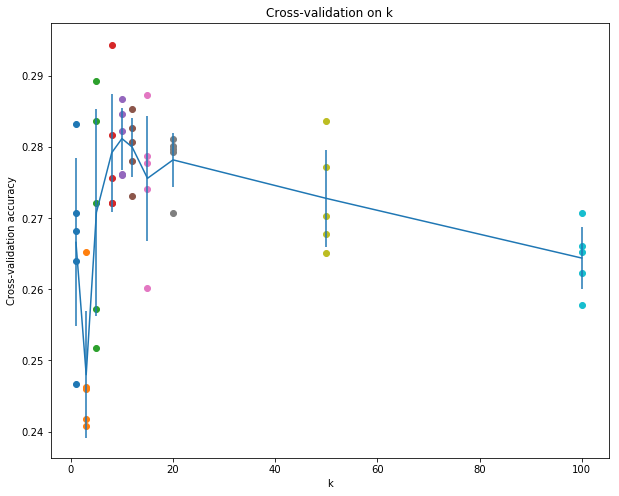

In [ ]:
# This plots the 5 accuracies per knn
for i in range(len(scores)):
    x=[k_choices[i]] * 5
    plt.scatter(x, scores[i])

# TODO : Use np.mean to get the average accuracy per knn
#        You will need to use the axis parameter here
# Output : Your output should have a shape of (10,)
### START CODE HERE ###
avg_scores = None
### END CODE HERE ###


# TODO : Use np.stddev to get the stddev per knn
#        You will need to use the axis parameter here
# Output : Your output should have a shape of (10,)
### START CODE HERE ###
stddev_scores = None
### END CODE HERE ###


# Plots the mean across k's, and the std dev of the accuracies per k
plt.errorbar(k_choices, avg_scores, yerr=stddev_scores)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')

In [ ]:
from sklearn import metrics
print(classification_report(y_train, predictions))

# TODO : Get the accuracy using metrics.accuracy_score
### START CODE HERE ###
print(None)
### END CODE HERE ###

             precision    recall  f1-score   support

          0       0.34      0.45      0.38       505
          1       0.53      0.05      0.10       460
          2       0.19      0.42      0.26       519
          3       0.30      0.09      0.14       486
          4       0.20      0.51      0.29       519
          5       0.48      0.12      0.20       488
          6       0.30      0.27      0.28       519
          7       0.50      0.11      0.18       486
          8       0.34      0.57      0.42       520
          9       0.60      0.10      0.18       498

avg / total       0.37      0.28      0.25      5000

0.2756


In [ ]:
# TODO : Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
### START CODE HERE ###
best_k = None
### END CODE HERE ###

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict_labels(X_test, k=best_k)

# TODO : Compute and display the accuracy
### START CODE HERE ###
num_correct = (y_test_pred==y_test).astype(int).sum()
accuracy = num_correct / (y_test.shape[0])
### END CODE HERE ###
print("Got %d / %d correct => accuracy: %f" % (num_correct, num_test, accuracy))

Got 41 / 500 correct => accuracy: 0.082000



<h3><center>fin</center></h3>

<!-- DO NOT MODIFY OR DELETE THIS -->
<b><sup>Resources:</sup></b>
<ul>
    <sup><li>Stanford cs231n course materials</li></sup>
</ul>

<sup>made/compiled by daniel stanley tan & courtney anne ngo 🐰 & thomas james tiam-lee</sup> <br>
<sup>for comments, corrections, suggestions, please email:</sup><sup> danieltan07@gmail.com & courtneyngo@gmail.com & thomasjamestiamlee@gmail.com</sup><br>
<sup>please cc your instructor, too</sup>
<!-- DO NOT MODIFY OR DELETE THIS -->